In [237]:
using NBInclude
@nbinclude("julia_function.ipynb")

allskyevents_free_eres (generic function with 1 method)

In [238]:
using StatProfilerHTML

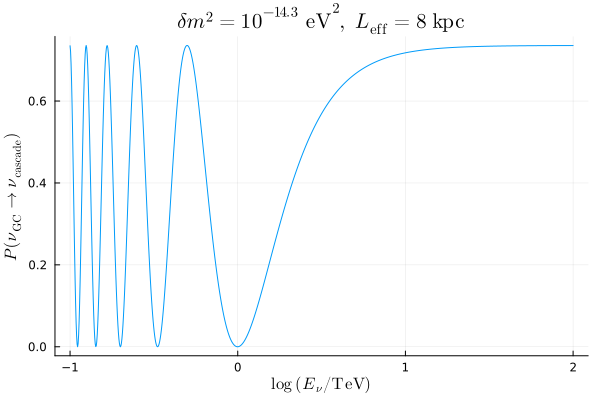

In [239]:
# Checking and plotting the oscillation probabilities

dm2 = 10^(-14.3); leff = 8

logerange = range(-1, 2, 1000)
erange = 10 .^ logerange

pe = osce.(erange, dm2, leff)
pτ = oscτ.(erange, dm2, leff)
pμ = oscμ.(erange, dm2, leff)
ps = @. 1 - pe - pτ - pμ
p_casc = oscprob.(erange, dm2, leff)

plot(
    logerange,
    p_casc,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"P(\nu_{\mathrm{GC}} \to \nu_{\mathrm{cascade}})",
    label=false,
    title=L"\delta m^2 = 10^{-14.3}~\mathrm{eV}^2,~L_\mathrm{eff} = 8~\mathrm{kpc}"
)

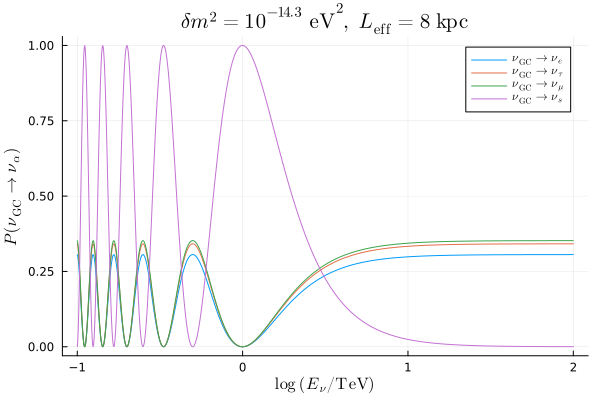

In [240]:

plot(
    logerange,
    [pe pτ pμ ps],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"P(\nu_{\mathrm{GC}} \to \nu_{\alpha})",
    label=[L"\nu_{\mathrm{GC}} \to \nu_e" L"\nu_{\mathrm{GC}} \to \nu_{\tau}" L"\nu_{\mathrm{GC}} \to \nu_{\mu}" L"\nu_{\mathrm{GC}} \to \nu_{s}"],
    title=L"\delta m^2 = 10^{-14.3}~\mathrm{eV}^2,~L_\mathrm{eff} = 8~\mathrm{kpc}"
)

In [241]:
# Checking that the total event number is ~748 for just all sky flux

function allskyflux(et, γ)
    ϕ₀ = 21.8e-16 * 3.156e8 # TeV cm^(-2)
    e0 = 100 # TeV
    flx = ϕ₀ * (et/e0)^(-γ) * effarea(et) * 10000
end

# Log integral with jacobian
function logintegral(γ)
    nsteps = 200
    us = range(log10(emin), log10(emax), nsteps) # emin = 0.725 TeV, emax = 1100 TeV
    du = us[2] - us[1]
    steps = allskyflux.((10 .^ us), γ) .* du .* (10 .^ us) .* log(10)
    int = sum(steps)
end

# True integral without jacobian
function trueintegral(γ)
    nsteps = 100000
    es = range(emin, emax, nsteps)
    de = es[2] - es[1]
    steps = allskyflux.(es, γ) .* de
    int = sum(steps)
end

logint = logintegral(2.7)
trueint = trueintegral(2.7)
println("log integral: $logint \ntrue integral: $trueint")

log integral: 739.4983671347962 
true integral: 738.7058492403846


In [242]:
# What if integrate in log space but we don't include a jacobian?

function logintegral_nojac(γ)
    nsteps = 200
    us = range(log10(emin), log10(emax), nsteps) # emin = 0.725 TeV, emax = 1100 TeV
    du = us[2] - us[1]
    steps = allskyflux.((10 .^ us), γ) .* du # no jacobian
    int = sum(steps)
end

logint_nojac = logintegral_nojac(2.7)

104.84435563110549

In [243]:
# Checking that the spatial PDF and energy distribution are independent: number should approach 748 (or 738 in our effective-area-digitized approximation) as sampling density increases

function weightedskyflux(et, γ, l, b, θ)
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)

    vols = blength .* sbinarea.(rbins, l, b, θ) # sbinarea is the volume of the spatial bin at a given distance r from Earth

    pds = probdens.(cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b))

    losint = sum(vols .* pds .* allskyflux(et, γ))
end

function weightedintegral(γ, nb)
    
    function esteps(et, γ, nb)

        bsize = π/nb

        b_range = (-π/2+bsize):bsize:(π/2-bsize)
        l_range = (0+bsize/2):bsize:(2π-bsize/2)

        skybins = []
        for l in l_range
            for b in b_range
                push!(skybins, weightedskyflux(et, γ, l, (-b), bsize))
            end
        end
        return sum(skybins)
    end

    nsteps = 200
    us = range(log10(emin), log10(emax), nsteps)
    du = us[2] - us[1]
    steps = esteps.((10 .^ us), γ, nb) .* du .* (10 .^ us) .* log(10)
    int = sum(steps)
end

weightedintegral (generic function with 1 method)

In [275]:
# Good agreement

weightedintegral(2.7, 200)

746.7316962966071

In [262]:
# Checking the energy smearing PDF

dm2 = 10^(-14); l = 0; b = 0; σ = 0.5; ϕ₀ = 21.8; γ = 2.7; θ = 0.122; nsteps = 100

# Mutates emptymat and ur
function fstrippedmat!(emptymat, ur, dm2, l, b, θ, ϕ₀, γ)
    ur .= 10 .^ ur
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)
    for i in 1:length(ur)
        for j in 1:length(rbins)
            vols = blength * oscprob(ur[i], dm2, rbins[j]) * sbinarea(rbins[j], l, b, θ)
            emptymat[j, i] = vols
        end 
    end
    flx = fluxfreeparams1(ur, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
    vec(sum(flx .* emptymat, dims=1)) .* (effarea.(ur) * 10000)
end

# The 0.5's are sorta arbitrary constants that shift the function enough to provide correct results (hehe)
samples = range(-1, log10(emax)+1, length=1000)
de = samples[2]-samples[1]

# Altered PDF from the Galactic plane paper
pdf_func(ur) = @. log(10) * exp10(ur - 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
gsample = pdf_func(samples)
g_fft = fft(gsample)

emptymat = zeros(61, length(samples)) # 61 from the sampling frequency along r
fsample = fstrippedmat!(emptymat, collect(samples), dm2, l, b, θ, ϕ₀, γ)
f_fft = fft(fsample)
C = f_fft .* g_fft
c = real(ifft(C)) .* de

# Again shifting the function to fit with expectation
cut = trunc(Int, (1)/de)
c1 = vcat(c[(cut+1):end], zeros(cut))

fg = Interpolations.interpolate((samples,), c1, Gridded(Linear()))

loges = range(log10(emin), log10(emax), nsteps)

-0.13970910365372904:0.03213197425937285:3.041356348024183

In [258]:
# Testing that the convolution and the integral smearing implementations converge

using QuadGK

dm2 = 10^(-14); l = 0; b = 0; σ = 0.5; ϕ₀ = 21.8; γ = 2.7; θ = 0.122; nsteps = 100

function f(ut)
    et = 10.0^ut
    r0, rmax = 0, 30
    blength = 0.5
    rbins = range(r0, stop=rmax, step=blength)

    # vols = @. blength * pi * (rbins * tan(θ)) ^ 2
    vols = blength .* sbinarea.(rbins, l, b, θ) .* oscprob.(et, dm2, rbins)

    flx = fluxfreeparams(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ)
    effa = effarea(et)[1]*10000

    sum(.*(flx, vols, effa))
end

pdf_func_test(ur, ut, σ) = log(10) * exp10(ur - ut) * pdf(Normal(0, σ), abs(1 - exp10(ur - ut)))

function testintegral(ur, σ)
    function testintegrand(ut)
        f(ut)*pdf_func_test(ur, ut, σ)
    end
    int = quadgk(ut -> testintegrand(ut), ur-3σ, ur+3σ)[1]
end

testintegral (generic function with 1 method)

In [260]:
# unsmeared = f.(samples)
smeared = testintegral.(samples, 0.5)

1000-element Vector{Float64}:
 0.18868068460174098
 0.19173475505009713
 0.1948384209134576
 0.19799331330080505
 0.2012009447174156
 0.20446296765918037
 0.20778132018454426
 0.2111576080239956
 0.21459342828761424
 0.21809039703383504
 0.22165017003772167
 0.22527442134382006
 0.22896487260328982
 ⋮
 1.3972984675511393e-58
 5.453738798027299e-60
 1.9634180874495197e-61
 6.507205680418493e-63
 1.981386929898955e-64
 5.511960084753317e-66
 1.4129036208830916e-67
 3.2948432458089426e-69
 6.999329515644514e-71
 1.3514455270047093e-72
 2.3662395136243313e-74
 3.748095706120201e-76

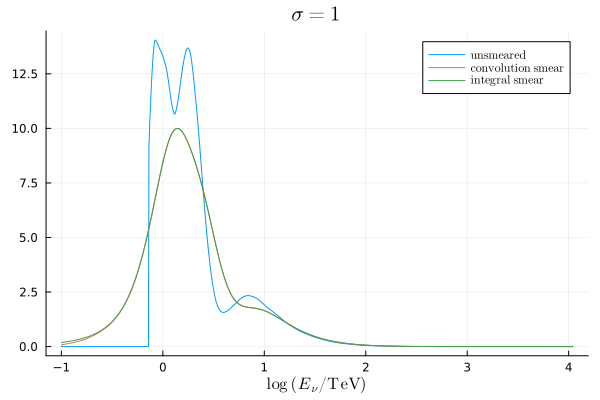

In [263]:
# Very good agreement between the integral and convolution smearing methods

plot(
    samples,
    [fsample fg.(samples) smeared],
    label=[L"\mathrm{unsmeared}" L"\mathrm{convolution~smear}" L"\mathrm{integral~smear}"],
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    title=L"\sigma = 1"
)

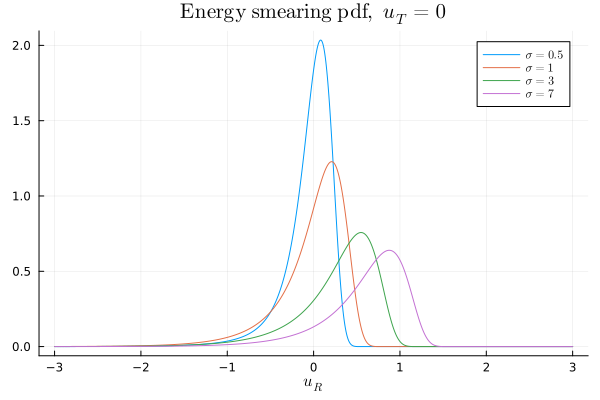

In [267]:
# pdf looks... weird

urs = range(-3, 3, 1000)
pdf_func_test(ur, ut, σ) = log(10) * exp10(ur - ut) * pdf(Normal(0, σ), abs(1 - exp10(ur - ut)))
plot(
    urs,
    [pdf_func_test.(urs, 0, 0.5) pdf_func_test.(urs, 0, 1) pdf_func_test.(urs, 0, 3) pdf_func_test.(urs, 0, 7)],
    label=[L"\sigma = 0.5" L"\sigma = 1" L"\sigma = 3" L"\sigma = 7"],
    title=L"\mathrm{Energy~smearing~pdf,}~u_T = 0",
    xlabel=L"u_R"
)

In [264]:
# Modeling behavior of this weird pdf

function pdfmax(σ)
    urs = range(-3, 3, 1000)
    pdffunc = pdf_func_test.(urs, 0, σ)
    for i in 1:1000
        if pdffunc[i] == maximum(pdffunc)
            return urs[i]
        end
    end
end

function pdfint(σ)
    return quadgk(ur -> pdf_func_test(ur, 0, σ), -100, 100)[1]
end
    


pdfint (generic function with 1 method)

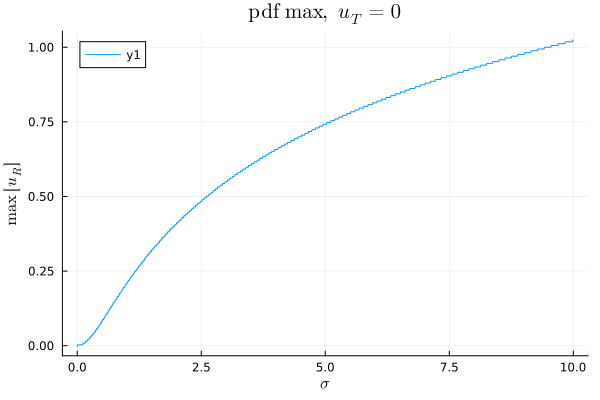

In [265]:
# pdf max looks like a log


σs = range(0.001, 10, 1000)
plot(
    σs,
    pdfmax.(σs),
    title=L"\mathrm{pdf~max},~u_T=0",
    xlabel=L"\sigma",
    ylabel=L"\mathrm{max}~[u_R]",
)

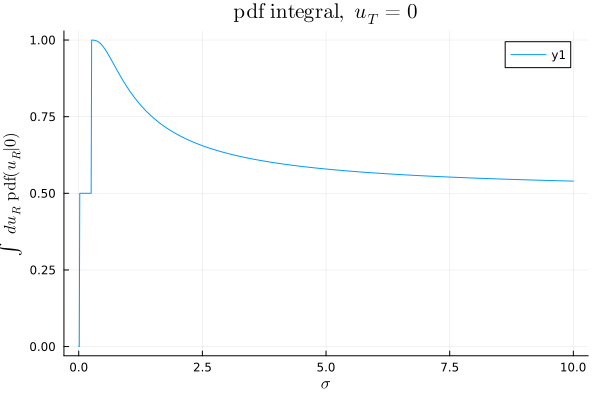

In [266]:
# Area under curve looks like an exp

plot(
    σs,
    pdfint.(σs),
    title=L"\mathrm{pdf~integral},~u_T = 0",
    xlabel=L"\sigma",
    ylabel=L"\int du_R~\mathrm{pdf}(u_R|0)"
)

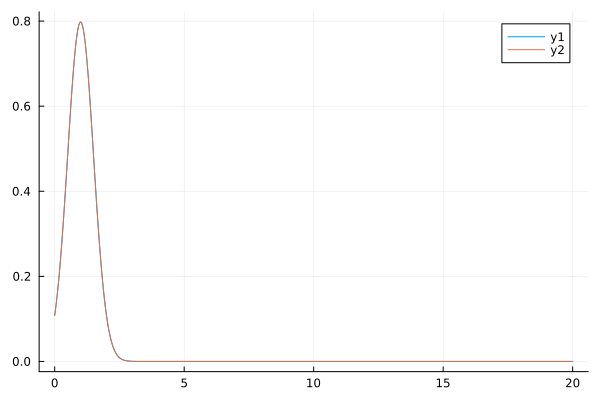

In [179]:
# Trying to rederive this pdf
# Test true energy pdf: er given et

function testpdf2(er, et, σ)
    return 1/(σ*sqrt(2π)) * exp(-1/2 * ((er - et)/(et*σ))^2)
end

function normpdf(er, et, σ)
    return 1/(σ*sqrt(2π)) * exp(-1/2 * ((er - et)/(σ))^2)
end

function testnormpdf(er, et, σ)
    return et * pdf(Normal(et, et*σ), er)
end

loges = range(-3, 5, 1000)
es = 10 .^ loges

es2 = range(0, 20, 1000)

plot(
    loges,
    log(10) .* es .* testpdf2.(es, 100, 5)
)

plot(
    es2,
    [testpdf2.(es2, 1, 0.5) testnormpdf.(es2, 1, 0.5)]
)

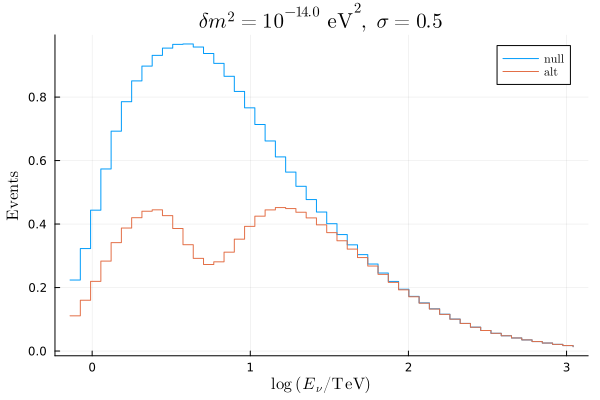

In [279]:
# Checking and plotting the binned smeared event dist

logerange = range(log10(emin), log10(emax), 50)
newedistfunc_alt = edistbinnedfreeparams(10^(-14.0), 0, 0, 0.5, 0.05, 21.8, 2.7)
newedistfunc_null = edistbinnedfreeparams(0, 0, 0, 0.5, 0.05, 21.8, 2.7)
plot(
    logerange,
    [newedistfunc_null newedistfunc_alt],
    seriestype=:step,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2,~\sigma = 0.5"
)

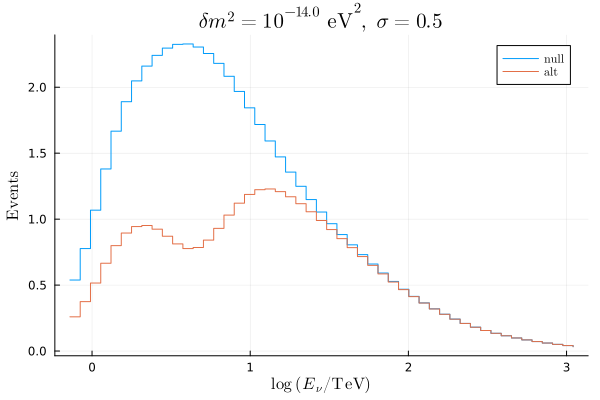

In [270]:
# (l, b) = (π/4, 0)

logerange = range(log10(emin), log10(emax), 50)
newedistfunc_alt = edistbinnedfreeparams(10^(-14.0), π/4, 0, 0.5, 0.122, 21.8, 2.7)
newedistfunc_null = edistbinnedfreeparams(0, π/4, 0, 0.5, 0.122, 21.8, 2.7)
plot(
    logerange,
    [newedistfunc_null newedistfunc_alt],
    seriestype=:step,
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}"],
    title=L"\delta m^2 = 10^{-14.0}~\mathrm{eV}^2,~\sigma = 0.5"
)

In [281]:
# Do the total number of events equal ~748? Yes

testallsky = allskyevents_free_eres(0, 21.8, 2.7, 0.05, 200)
sum(testallsky)

748.735939868193

In [283]:
function edistbinnedfreeparams_nojac(dm2, l, b, σ, θ, ϕ₀, γ)
    nbins = 50 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps) .* du
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

function allskyevents_free_eres_onejac(dm2, ϕ₀, γ, σ, nb)
    bsize = π/nb

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > 2nb/5 && i < 3nb/5 # the vast najority of events occur in this b range, so sampling like this vastly reduces the number of function calls necessary
                skybins[i, j] = edistbinnedfreeparams_nojac(dm2, l, (-b), σ, bsize, ϕ₀, γ)
            end
        end
    end

    return sum(skybins)
end

allskyevents_free_eres_onejac (generic function with 1 method)

In [284]:
# Without a jacobian we get nowhere near the correct event number

testallsky_onejac = allskyevents_free_eres_onejac(0, 21.8, 2.7, 0.05, 200)
sum(testallsky_onejac)

103.27382876742192

In [285]:
# nb = 100 is around 0.94 the true event number

testallsky1 = allskyevents_free_eres(0, 21.8, 2.7, 0.05, 100)
sum(testallsky) / sum(testallsky1)

0.9355099741114988

In [287]:
# Testing the angular smearing, looks pretty good

smeared = anglesmear(0, 21.8, 2.7, 0.05, 7, 200)
sum(sum(smeared))

751.6917140278902

In [288]:
# Testing different minimization routines

function allskynllh_test(dm2, ϕ₀, γ, σ, res)

    res_rad = res * (π/180)

    sumllh = 0

    # This sampling gets the majority of events and gives an *almost* maximized parameter set
    for lval in (-pi/2):res_rad:(pi/2)
        for bval in (-0.122):res_rad:(0.122)
            sumllh += negloglh2(dm2, lval, bval, σ, res_rad, ϕ₀, γ)
        end
    end
    
    return sumllh
end

function allskymaxlh_test_LBFGS(dm2, σ, res)

    function nllh(test)
        return allskynllh_test(dm2, test[1], test[2], σ, res)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, LBFGS())
end

function allskymaxlh_test_NelderMead(dm2, σ, res)

    function nllh(test)
        return allskynllh_test(dm2, test[1], test[2], σ, res)
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end

allskymaxlh_test_NelderMead (generic function with 1 method)

In [145]:
maxlh_test_null = Optim.minimum(allskymaxlh_test_NelderMead(0, 0.5, 7))

1180.9936430885862

In [142]:
maxlh_test_03 = Optim.minimum(allskymaxlh_test_NelderMead(10^(-14.4), 0.5, 3))
maxlh_test_07 = Optim.minimum(allskymaxlh_test_NelderMead(10^(-14.4), 0.5, 7))
maxlh_test_12 = Optim.minimum(allskymaxlh_test_NelderMead(10^(-14.4), 0.5, 12))

265.81377942908387

In [143]:
maxlh_test_03

1593.749947817503

In [144]:
maxlh_test_07

1228.2425410473709

In [154]:
function maxlh_allskyevents(dm2, σ)
    mxlhallsky = allskymaxlh(dm2, σ, 1.8)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    nb = 100
    bsize = π/nb

    b_range = (-π/2+bsize):bsize:(π/2-bsize)
    l_range = (0+bsize/2):bsize:(2π-bsize/2)

    # Going to be a vector of vectors
    skybins = [zeros(50) for _ in 1:length(b_range), _ in 1:length(l_range)]

    for (j, l) in enumerate(l_range)
        for (i, b) in enumerate(b_range)
            if i > nb/4 && i < 3*nb/4
                skybins[i, j] = edistbinnedfreeparams(dm2, l, (-b), σ, bsize, allskymaxparams[1], allskymaxparams[2])
            end
        end
    end

    return sum(skybins)
end

maxlh_allskyevents (generic function with 1 method)

In [98]:
eress = range(0.1, 1, 10)
angres7 = 7
ts_angres7 = allskyts_real.(10^(-14.4), eress, angres7)

10-element Vector{Float64}:
 66.85031077890595
 59.25650537411275
 52.15607729304867
 47.14381718403644
 44.009269289512915
 42.16850931722672
 41.17283998446409
 40.73726850899813
 40.68174226732235
 40.89262387099196

In [241]:
eress = range(0.1, 1, 10)
eventss = maxlh_allskyevents.(10^(-14.0), eress)

10-element Vector{Vector{Float64}}:
 [15.415141745722966, 27.335200765932722, 31.0628258768173, 33.084026777636346, 36.13518338333017, 38.67749093367464, 37.64600190342151, 33.05348661262752, 27.571252526938732, 23.618837592594033  …  1.38301642809003, 1.1476474556193617, 0.956876107277834, 0.7956133065165388, 0.6565145182918756, 0.5343984551682348, 0.4289654399407722, 0.3497561977551815, 0.2862786392724057, 0.193445535489992]
 [13.784148884964402, 22.920195386463945, 29.67119243073029, 33.09559356704882, 35.301861222092064, 36.75716196510024, 36.3141691609335, 33.437424548358244, 29.28511830722254, 25.781330622036414  …  1.4323297265019552, 1.188267245709036, 0.9865716061248726, 0.818862832429043, 0.6760661035912512, 0.5529487547554428, 0.44741592986629486, 0.3581010548055352, 0.27859443958339786, 0.19566040089099626]
 [12.582926295318437, 19.467975070342497, 26.317589959545906, 31.254286796795757, 33.94450036288583, 35.19802637528433, 35.23930325645212, 33.77123913034778, 31.02627251

In [242]:
writedlm("misc_data/total_allsky_events_140_diff_eres.txt", eventss)

In [168]:
eventss_null = allskyevents.(0, eress, 21.8, 2.7, 100)

10-element Vector{Vector{Float64}}:
 [11.508279760122715, 21.11894262619538, 25.49423726175278, 28.303496302867917, 30.77754782078816, 32.95168675218605, 34.51068640471847, 35.69930933820625, 36.69872963865293, 37.08137242381858  …  1.9393954372721547, 1.6649680678589838, 1.4360026407009174, 1.2349997639589176, 1.053981969641245, 0.8872428022114623, 0.7367455096866324, 0.6217286321701219, 0.5257674055218858, 0.36468693374124656]
 [10.57298681764252, 17.95416706567098, 24.001406900545007, 27.706381115862563, 30.283515661585497, 32.40643759650946, 34.10922262105391, 35.381050605490174, 36.287625851594996, 36.81355186476528  …  2.0028469611960262, 1.7193693531321061, 1.4772323685463074, 1.268487012972332, 1.0832159728339879, 0.9162470199038, 0.7666665081515391, 0.6341089582335249, 0.508306044577804, 0.36577241884021816]
 [9.886920658340106, 15.492789899573497, 21.37356039747735, 26.110390328206147, 29.328252606320167, 31.61209053390077, 33.398889483389986, 34.77128198036291, 35.7369767680

In [243]:
eventss_alt = allskyevents.(10^(-14.0), eress, 21.8, 2.7, 100)

10-element Vector{Vector{Float64}}:
 [5.68770394781344, 10.291106943652856, 12.05987027065665, 13.291999800410299, 15.022057945043766, 16.610796166443393, 16.690484088400698, 15.137896754114282, 13.060545395764601, 11.591931869301478  …  1.9388464727117172, 1.6646170076277138, 1.435776822214117, 1.2348547933433782, 1.0538895356684206, 0.8871846255342938, 0.7367094628564117, 0.621706045071663, 0.5257530367978172, 0.3646790365245045]
 [5.154943019671462, 8.687885939866693, 11.500150595027815, 13.220472056500883, 14.569036932959463, 15.651008940135245, 15.93525963815654, 15.13635805210379, 13.71632542523465, 12.54141531943264  …  2.0022000776426707, 1.718955050398215, 1.4769669987264011, 1.2683167902682069, 1.0831071531045642, 0.916178040812454, 0.7666232442431292, 0.634082055827854, 0.508289516251095, 0.365762887474785]
 [4.781265298562392, 7.465086599477569, 10.2443929483378, 12.438758980798145, 13.892251348023333, 14.843745556752701, 15.311600948599308, 15.1306456591461, 14.37670575387

In [244]:
sum_eventss = zeros(10)
for i in 1:length(eventss)
    sum_eventss[i] = sum(eventss[i])
end

sum_eventss_null = zeros(10)
for i in 1:length(eventss_null)
    sum_eventss_null[i] = sum(eventss_null[i])
end

sum_eventss_alt = zeros(10)
for i in 1:length(eventss_alt)
    sum_eventss_alt[i] = sum(eventss_alt[i])
end

In [170]:
sum_eventss_null

10-element Vector{Float64}:
 801.659238844918
 796.7998317557582
 792.1941011997747
 789.4768382625218
 790.543847687167
 796.1671943464571
 806.0834482379319
 819.6371898634793
 836.14335758985
 855.0113657213155

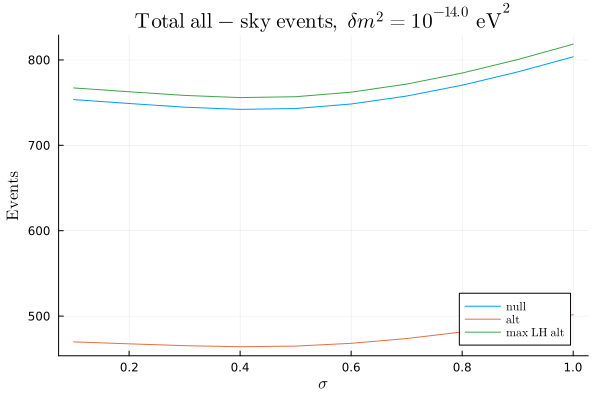

In [245]:
plot(
    eress,
    [sum_eventss_null*0.94 sum_eventss_alt*0.94 sum_eventss*0.94],
    xlabel=L"\sigma",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}" L"\mathrm{max~LH~alt}"],
    title=L"\mathrm{Total~all-sky~events},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2"
)

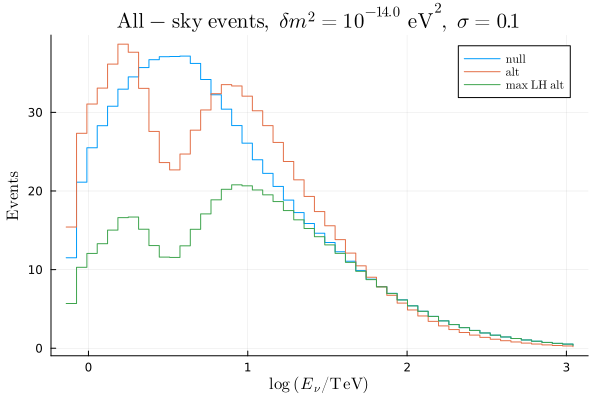

In [254]:
ebins = range(log10(emin), log10(emax), 50)
plot(
    ebins,
    [eventss_null[1] eventss[1] eventss_alt[1]],
    seriestype=:step,
    title=L"\mathrm{All-sky~events},~\delta m^2 = 10^{-14.0}~\mathrm{eV}^2,~\sigma = 0.1",
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}" L"\mathrm{max~LH~alt}"]
)

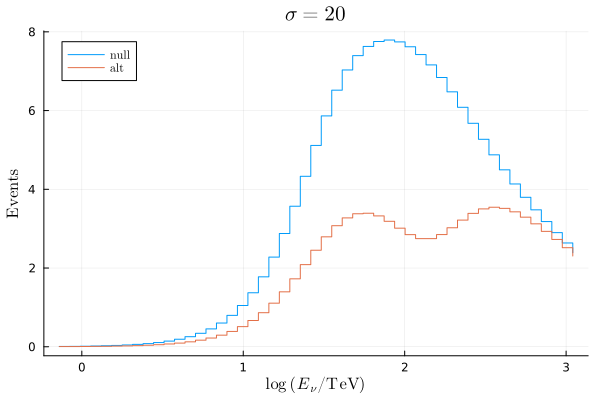

In [228]:
plot(
    ebins,
    [edistbinnedfreeparams(0, 0, 0, 20, 0.05, 21.8, 2.7) edistbinnedfreeparams(10^(-14), 0, 0, 20, 0.05, 21.8, 2.7)],
    seriestype=:step,
    title=L"\sigma = 20",
    xlabel=L"\log~(E_{\nu} / \mathrm{TeV})",
    ylabel=L"\mathrm{Events}",
    label=[L"\mathrm{null}" L"\mathrm{alt}" L"\mathrm{max~LH~alt}"]
)

In [84]:
for i in 1:length(ts_angres7)
    if ts_angres7[i] < 0
        ts_angres7[i] = 0
    end
end

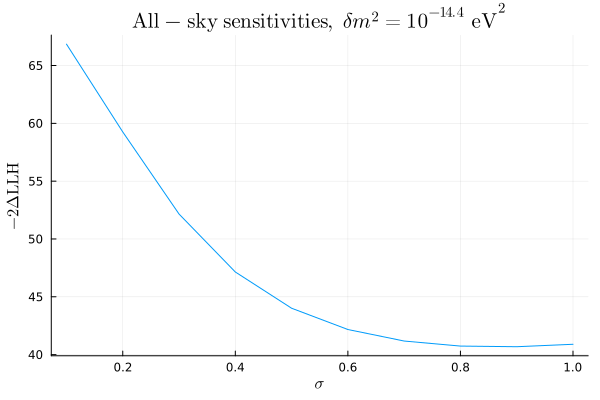

In [102]:
plot(
    eress,
    ts_angres7,
    xlabel=L"\sigma",
    ylabel=L"-2 \Delta \mathrm{LLH}",
    label=false,
    title=L"\mathrm{All-sky~sensitivities},~\delta m^2 = 10^{-14.4}~\mathrm{eV}^2"
)

In [103]:
# savefig("misc_plots/updated_allsky_sensitivities_varying_sigma_7_angres.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/misc_plots/updated_allsky_sensitivities_varying_sigma_7_angres.png"

In [86]:
allskyts_real(10^(-14.4), 0.3, 7)

-Inf

In [87]:
maxlh03 = allskymaxlh(10^(-14.4), 0.3, 7)
maxlh03params = Optim.minimizer(maxlh03)

2-element Vector{Float64}:
 14.781841238578064
  2.97549040327051

In [89]:
function allskyts_real_test2(dm2, σ, θres)

    mxlhallsky = allskymaxlh(dm2, σ, θres)
    allskymaxparams = Optim.minimizer(mxlhallsky)

    askyevents_null = anglesmearbin(0, 21.8, 2.7, σ, θres, 100) * 0.94
    askyevents_alt_maxlh = anglesmearbin(dm2, allskymaxparams[1], allskymaxparams[2], σ, θres, 100) * 0.94

    bsize, lsize = size(askyevents_null)
    ts_vals = zeros(bsize, lsize)

    for j in 1:lsize
        for i in 1:bsize
            ts_vals[i, j] = lrt(askyevents_null[i, j], askyevents_alt_maxlh[i, j])
        end
    end
    
    return ts_vals
end

allskyts_real_test2 (generic function with 1 method)

In [139]:
tss_03 = allskyts_real_test2(10^(-14.4), 0.5, 3)

60×120 Matrix{Float64}:
 -0.0          -0.0          -0.0          …  -0.0          -0.0
 -0.0          -0.0          -0.0             -0.0          -0.0
  6.55536e-10   1.44865e-9   -0.0              3.62315e-11   1.32561e-9
 -0.0           2.51823e-10   2.78622e-11      9.06555e-11  -0.0
  7.15981e-11  -0.0           7.82925e-11     -0.0           1.10497e-10
 -0.0          -0.0           1.9019e-11   …  -0.0           2.81613e-11
 -0.0           5.25469e-11  -0.0             -0.0           1.9589e-10
  9.78551e-13  -0.0           2.56573e-12     -0.0          -0.0
 -0.0           6.24389e-13   4.37317e-12      6.8856e-13   -0.0
  3.32623e-13  -0.0           2.44205e-12      1.14828e-11   1.31783e-12
  1.00009e-12  -0.0          -0.0          …  -0.0           1.18927e-12
  1.82965e-13  -0.0          -0.0              7.77156e-14   1.66533e-13
  1.40332e-13  -0.0           1.03029e-13      7.90479e-14   6.66134e-15
  ⋮                                        ⋱                
  1.7497

In [140]:
sum(sum(tss_03))

42.73121947252927

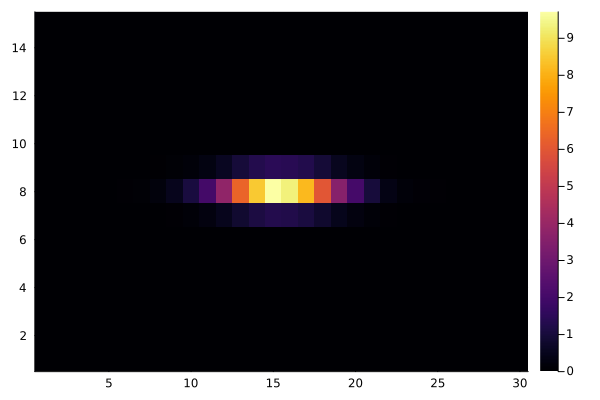

In [108]:
heatmap(tss_03)

In [104]:
angres12 = 12
ts_angres12 = allskyts_real.(10^(-14.4), eress, angres12)

10-element Vector{Float64}:
 107.76220860569492
  99.45201369059312
  90.6993879735885
  84.20910872539014
  80.24078046202034
  78.14410438156696
  77.32547711788979
  77.36083667641378
  77.988511082853
  79.04090462088348

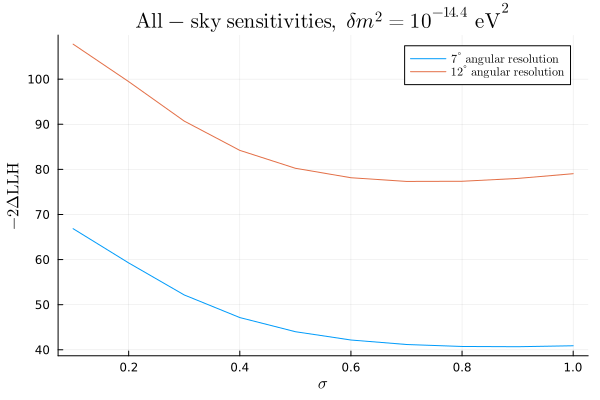

In [111]:
plot(
    eress,
    [ts_angres7 ts_angres12],
    xlabel=L"\sigma",
    ylabel=L"-2 \Delta \mathrm{LLH}",
    label=[L"7^{\circ}~\mathrm{angular~resolution}" L"12^{\circ}~\mathrm{angular~resolution}"],
    title=L"\mathrm{All-sky~sensitivities},~\delta m^2 = 10^{-14.4}~\mathrm{eV}^2"
)

In [7]:
5*31/60

2.5833333333333335

In [8]:
logdm2s = range(-15, -12, 21)
dm2s = 10 .^ logdm2s

21-element Vector{Float64}:
 1.0e-15
 1.4125375446227554e-15
 1.995262314968883e-15
 2.818382931264449e-15
 3.9810717055349695e-15
 5.6234132519034904e-15
 7.943282347242822e-15
 1.1220184543019652e-14
 1.584893192461111e-14
 2.2387211385683377e-14
 3.1622776601683796e-14
 4.466835921509635e-14
 6.309573444801943e-14
 8.912509381337441e-14
 1.2589254117941663e-13
 1.7782794100389227e-13
 2.511886431509582e-13
 3.5481338923357605e-13
 5.011872336272715e-13
 7.079457843841374e-13
 1.0000000000000002e-12

In [236]:
collect(logdm2s)

21-element Vector{Float64}:
 -15.0
 -14.85
 -14.7
 -14.55
 -14.4
 -14.25
 -14.1
 -13.95
 -13.8
 -13.65
 -13.5
 -13.35
 -13.2
 -13.05
 -12.9
 -12.75
 -12.6
 -12.45
 -12.3
 -12.15
 -12.0

In [9]:
ts_angres3 = allskyts_real.(dm2s, 0.5, 3)
writedlm("misc_data/ts_angres3.txt", ts_angres3)

In [10]:
ts_angres7 = allskyts_real.(dm2s, 0.5, 7)
writedlm("misc_data/ts_angres7.txt", ts_angres7)

In [11]:
ts_angres12 = allskyts_real.(dm2s, 0.5, 12)


LoadError: SystemError: opening file "miscdata/ts_angres12.txt": No such file or directory

In [14]:
writedlm("misc_data/ts_angres12.txt", ts_angres12)

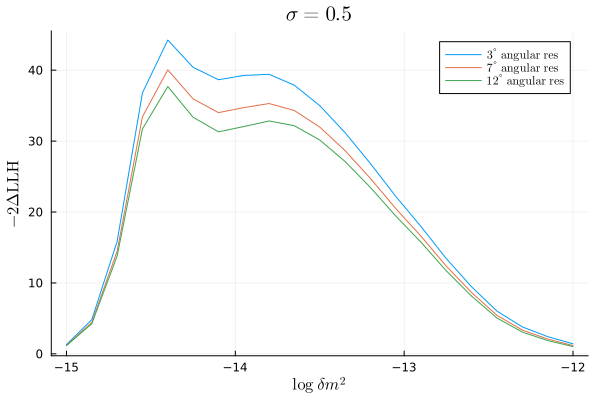

In [20]:
plot(
    logdm2s,
    [ts_angres3 ts_angres7 ts_angres12],
    label=[L"3^{\circ}~\mathrm{angular~res}" L"7^{\circ}~\mathrm{angular~res}" L"12^{\circ}~\mathrm{angular~res}"],
    xlabel=L"\log~\delta m^2",
    ylabel=L"-2 \Delta \mathrm{LLH}",
    title=L"\sigma = 0.5"
)

In [21]:
# savefig("allsky_ts_vary_angres_eres05")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/allsky_ts_vary_angres_eres05.png"

In [15]:
ts_eres01 = allskyts_real.(dm2s, 0.1, 7)
writedlm("misc_data/ts_eres01.txt", ts_eres01)

In [16]:
ts_eres1 = allskyts_real.(dm2s, 1, 7)
writedlm("misc_data/ts_eres01.txt", ts_eres1)

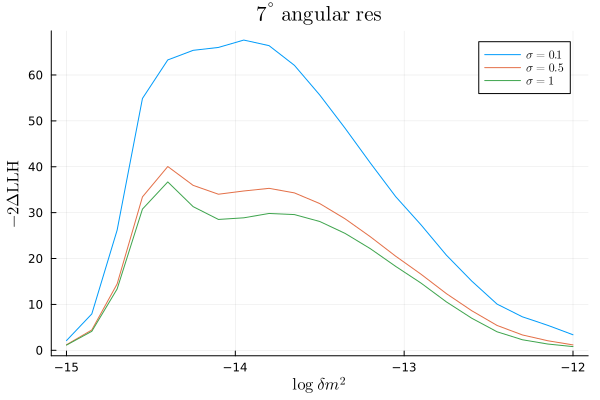

In [23]:
plot(
    logdm2s,
    [ts_eres01 ts_angres7 ts_eres1],
    xlabel=L"\log~\delta m^2",
    ylabel=L"-2 \Delta \mathrm{LLH}",
    title=L"7^{\circ}~\mathrm{angular~res}",
    label=[L"\sigma = 0.1" L"\sigma = 0.5" L"\sigma = 1"]
)

In [24]:
savefig("misc_plots/allsky_ts_vary_eres_angres7.png")

"/Users/millermacdonald/Desktop/Research_shit/Summer_2023_Research/GC_calcs/misc_plots/allsky_ts_vary_eres_angres7.png"

In [306]:
true_eres = readdlm("eres_matrix.dat")

200×200 Matrix{Float64}:
 -0.564923  -0.405258  -0.405258  …   0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258  …   0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258  …   0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
 -0.564923  -0.405258  -0.405258      0.0        0.0        0.0
  ⋮                               ⋱                        
 -0.419773   0.0        0.0          -1.98739   -1.98739   -1.98739
 -0.419773   0.

In [307]:
true_eres[1:25, 175:end] = zeros(25, 26)

25×26 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

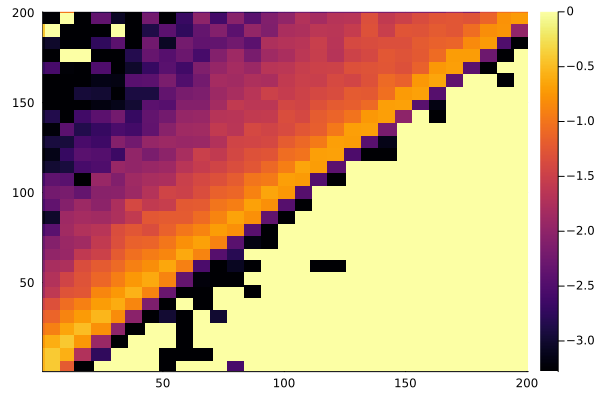

In [308]:
heatmap(true_eres)

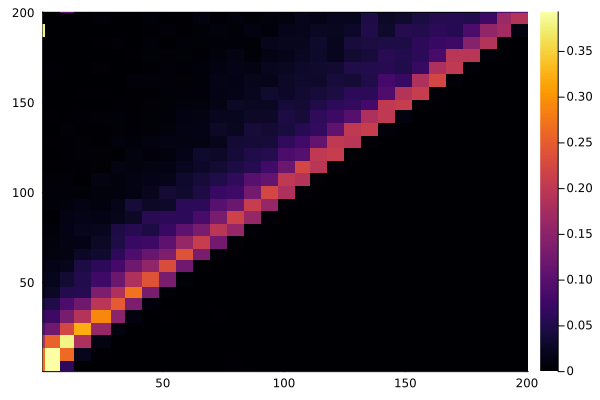

In [309]:
true_eres = 10 .^ true_eres

for j in 1:200
    for i in 1:200
        if true_eres[i, j] == 1
            true_eres[i, j] = 0
        end
    end
end

heatmap(true_eres)

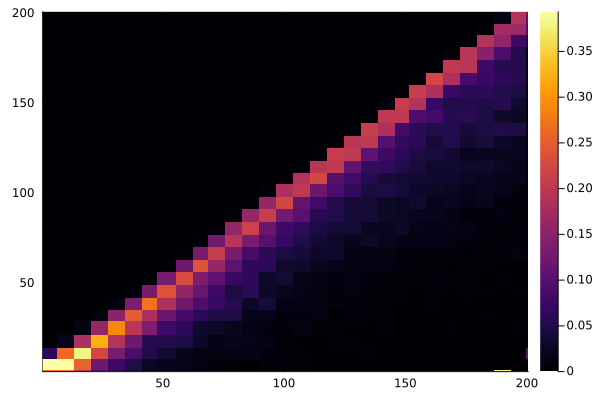

In [310]:
heatmap(transpose(true_eres))

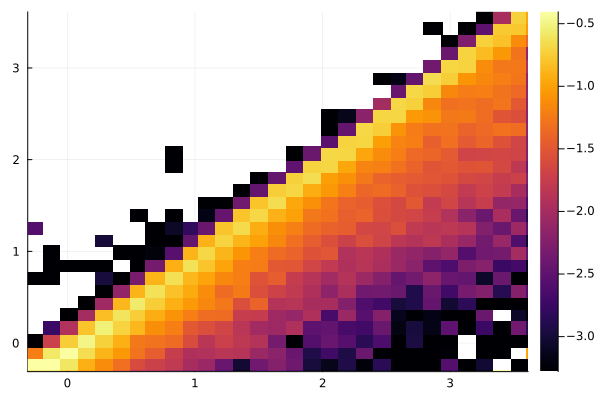

In [317]:
loges = range(log10(5e-1), log10(4e3), 200)

heatmap(
    loges,
    loges,
    transpose(log10.(true_eres))
)

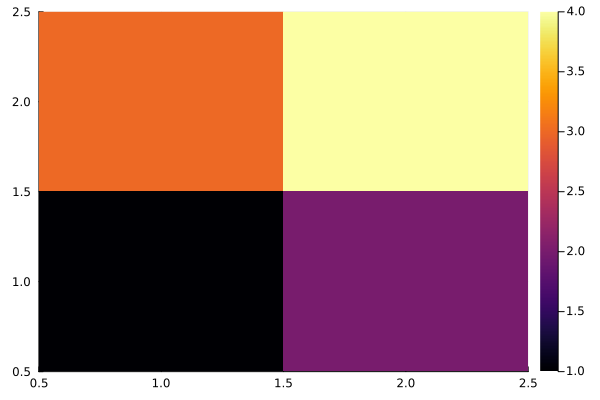

In [296]:
matrix = [1 2;
          3 4]

heatmap(matrix)